# Bayesian Learning in a Linear Basis Function Model

In this notebook we ilustrate the bayesian learning in a linear basis function model, as well as the sequential update of a posterior distribution.

Taken from Christopher Bishop's Pattern Recognition and Machine Learning book (p.155)

In [43]:
import numpy as np
from numpy.random import seed, uniform, randn
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
%config InlineBackend.figure_format = "retina"

We consider an input $x$, a target variable $t$ and a linear model of the form
$$
    y(x, {\bf w}) = w_0 + w_1x
$$

In [3]:
def f(x, a): return a[0] + a[1] * x

In [4]:
seed(1643)
a = np.array([-0.3, 0.5])
N = 30
sigma = 0.2
X = uniform(-1, 1, (N, 1))
T = f(X, a) + randn(N, 1) * sigma

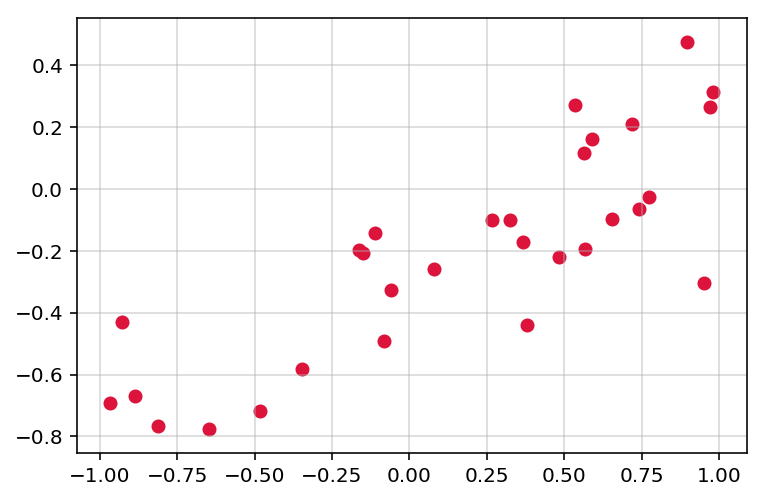

In [7]:
plt.scatter(X, T, c="crimson")
plt.grid(alpha=0.5)

Our goal is to recover the values $w_0$ and $w_1$ from the data.

Recall:
$$
    p({\textbf w}|t) \propto p(t| {\textbf w}, \beta) p(\bf{w})
$$

Where

* $w \sim \mathcal{N}\left(0, \alpha^{-1}\text{I}\right)$
* $t \sim \mathcal{N}\left({\bf w}^Tx, \beta^{-1}\right)$

In [9]:
beta = (1 / sigma) ** 2 # precision
alpha = 2.0

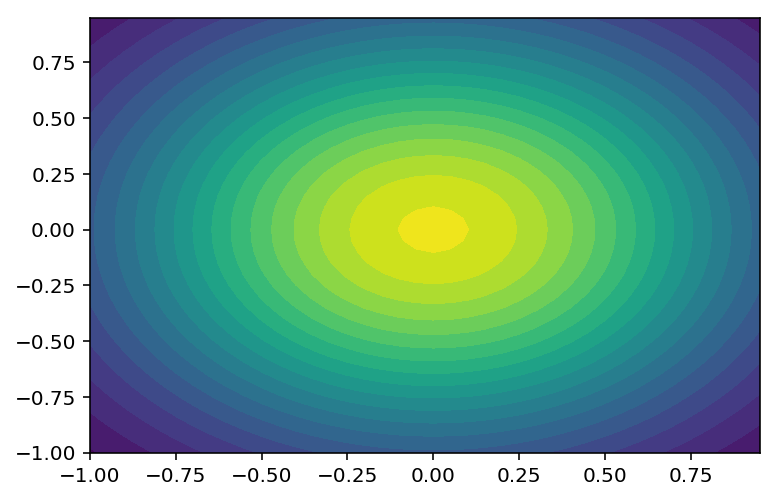

In [42]:
step = 0.05
grid = np.mgrid[-1:1:step, -1:1:step]
nx = grid.shape[-1]
z = multivariate_normal.pdf(grid.T.reshape(-1, 2), cov=np.identity(2) / alpha).reshape(nx, nx)
plt.contourf(*grid, z, levels=20)

The posterior distribution of $\bf w$ after $N$ observations is
$$
\begin{align}
    m_N &= \beta S_N\Phi^T0{\bf t} \\
    S_N^{-1} &= \alpha \text{I} + \beta\Phi^T\Phi
\end{align}
$$